## # ECE 9039 Final Project - MULTI-CLASS MUSIC GENRE CLASSIFICATION
### Contributors:
- Chukwuemeka Momodu
- Damilola Awotunde

In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# keras
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras import callbacks
from keras import Input # for instantiating a keras tensor

# metrics
from sklearn.metrics import log_loss, confusion_matrix

2023-03-28 23:35:29.103930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 23:35:29.282316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 23:35:29.282347: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 23:35:29.890001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# read dataset into pandas dataframe
data = pd.read_csv('./data/data.csv')
# save copy of data
original_data_copy = data.copy()

In [3]:
# print data shape
print("Dataset shape is: {0}".format(data.shape))

Dataset shape is: (17996, 17)


In [4]:
# show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
# view top 5 rows of dataset
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [6]:
# target column
target_col = 'Class'
# feature columns
feature_cols = []
for column in data.select_dtypes(exclude=["object"]).columns: # exclude Artist Name and Track Name columns with object dtype
    if column != 'Class': feature_cols.append(column) # exclude target variable
print("\nTarget column: {0}".format(target_col))
print("\nFeature columns: {0}".format(feature_cols))
print("\nNo of Features: {0}".format(len(feature_cols)))


Target column: Class

Feature columns: ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature']

No of Features: 14


## Exploratory Data Analysis (EDA)

                                   Visualising Target Column:                                   


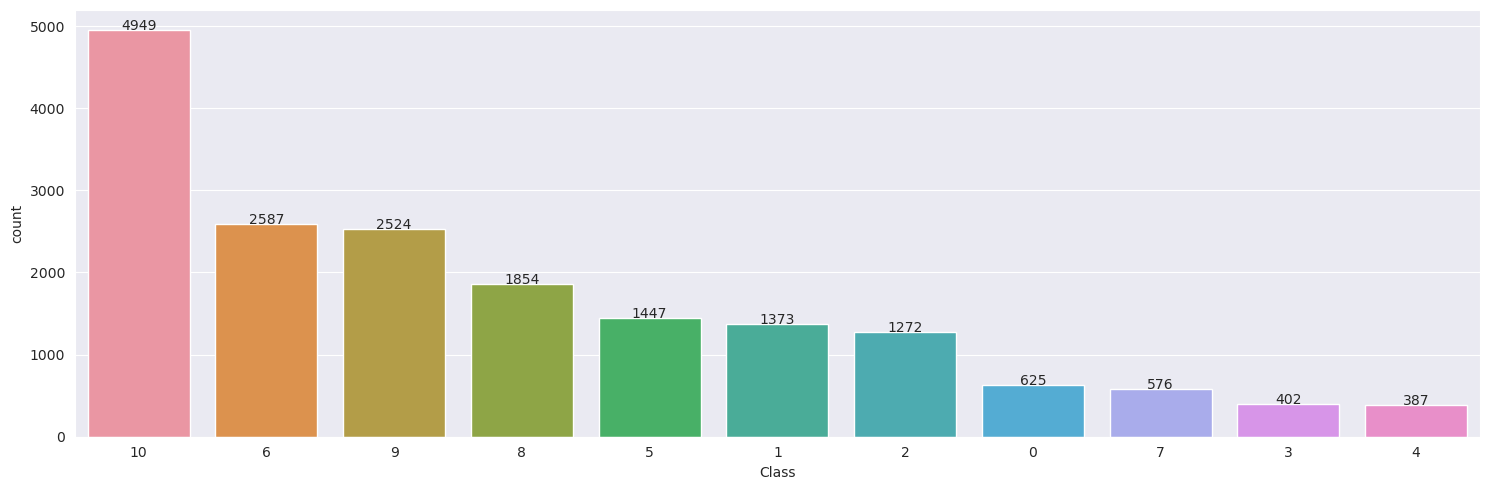

In [7]:
# Visualising the Target Column
print('\033[1mVisualising Target Column:'.center(100))
plt.figure(figsize=[15,5])
sns.countplot(x=data[target_col], order=data[target_col].value_counts().index)
plt.tight_layout()

# Get the count of occurrences for each category in the "target_col" column
counts = data[target_col].value_counts()

# Add count values on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v+1, str(v), ha="center")

plt.show()

In [8]:
# number of observations for each class in the train set
print("Number of observations for each class in data")
value_counts = data[target_col].value_counts()
for i in range(len(value_counts)):
    print("Class {0}: {1}".format(i, value_counts[i]))

Number of observations for each class in data
Class 0: 625
Class 1: 1373
Class 2: 1272
Class 3: 402
Class 4: 387
Class 5: 1447
Class 6: 2587
Class 7: 576
Class 8: 1854
Class 9: 2524
Class 10: 4949


In [9]:
# Find all categorical features with the condition of less than 50 unique value
categorical_cols_dict = {}
cat_cols_list = []
non_cat_cols_list = []
for column in feature_cols:
    num_unique_values = len(data[column].unique())
    if num_unique_values < 50:
        categorical_cols_dict[column] = num_unique_values
        cat_cols_list.append(column)
    else: non_cat_cols_list.append(column) # find non-categorical features

print("Categorical columns and number of classes\n")
print(pd.DataFrame({'Column': categorical_cols_dict.keys(), 'No of Classes': categorical_cols_dict.values()}))

Categorical columns and number of classes

           Column  No of Classes
0             key             12
1            mode              2
2  time_signature              4


                                Visualising Categorical Columns:                                


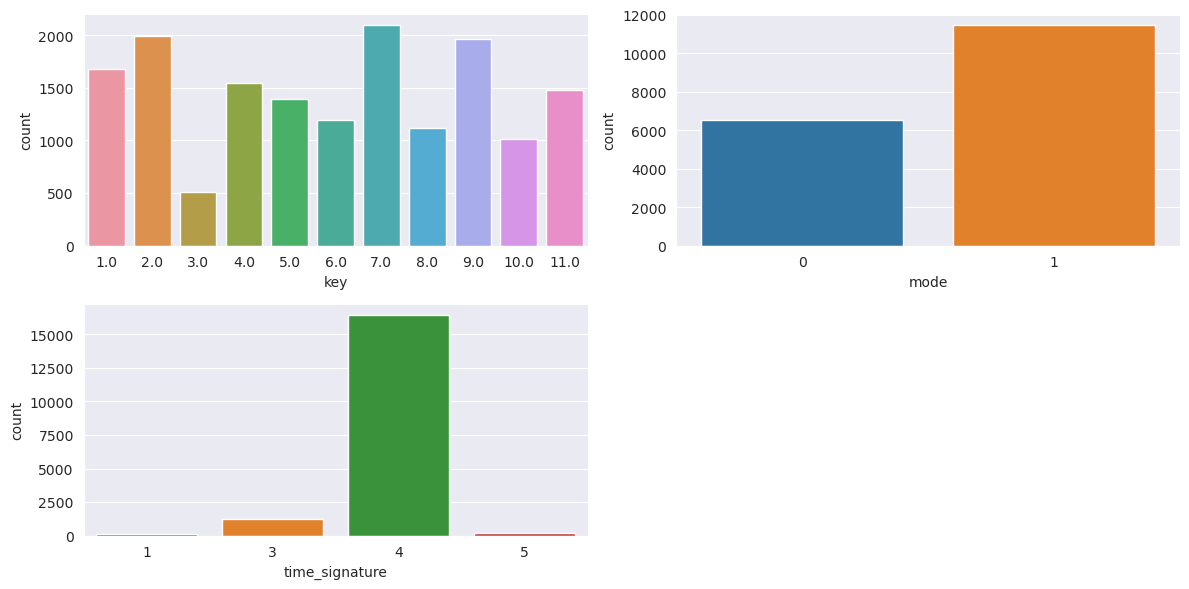

In [10]:
# Visualising the categorical Columns
print('\033[1mVisualising Categorical Columns:'.center(100))
n=2
cf = cat_cols_list
df = data
plt.figure(figsize=[12,3*math.ceil(len(cf)/n)])
for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf)/n),n,i+1)
    sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

                              Non-Categorical Columns Distribution                              


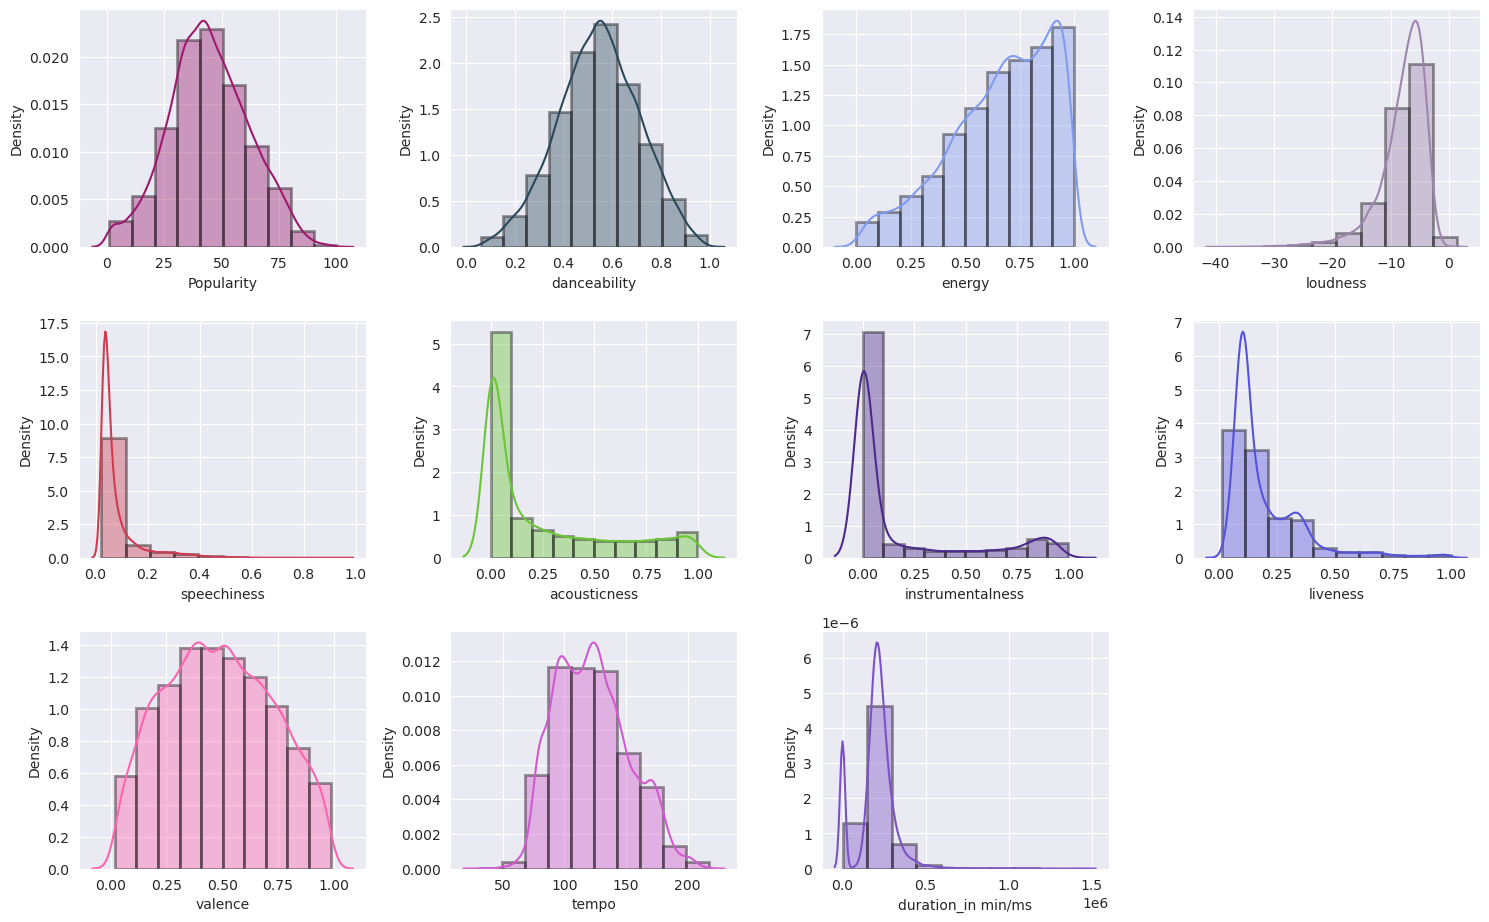

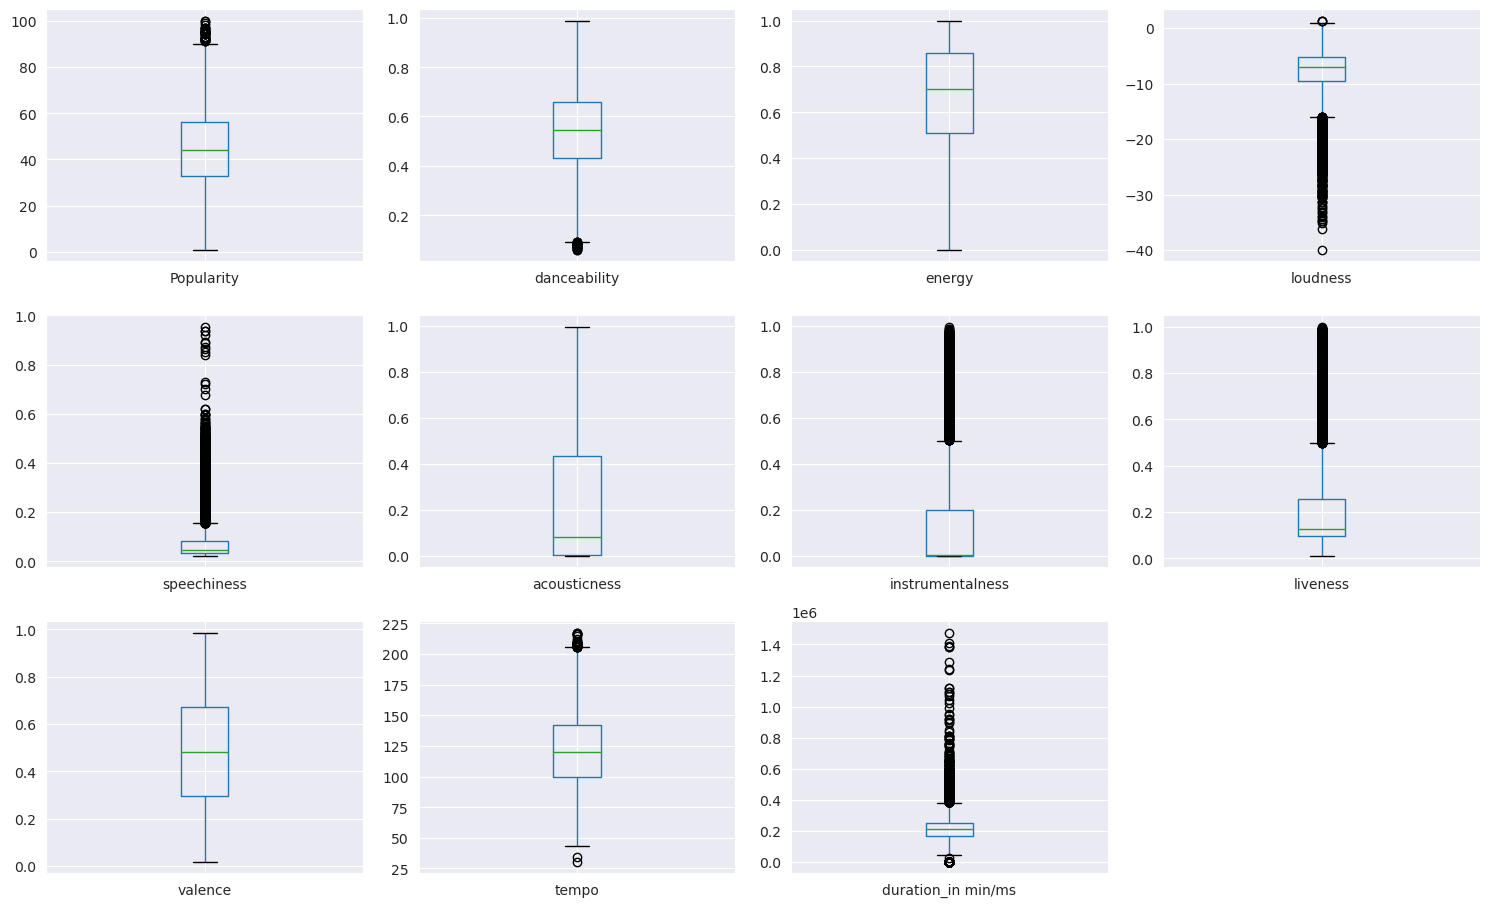

In [11]:
# Visualising the non-categorical columns
print('\033[1mNon-Categorical Columns Distribution'.center(100))
nf = non_cat_cols_list
n=4
clr=['r','g','b','g','b','r']
# plot distribution
plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(data[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()
# box plot
plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    data.boxplot(nf[i])
plt.tight_layout()
plt.show()

**Inference:** There seem to be some outliers as well as large scaled features. This would be fixed in the pre-processing step

                                       Correlation Matrix                                       


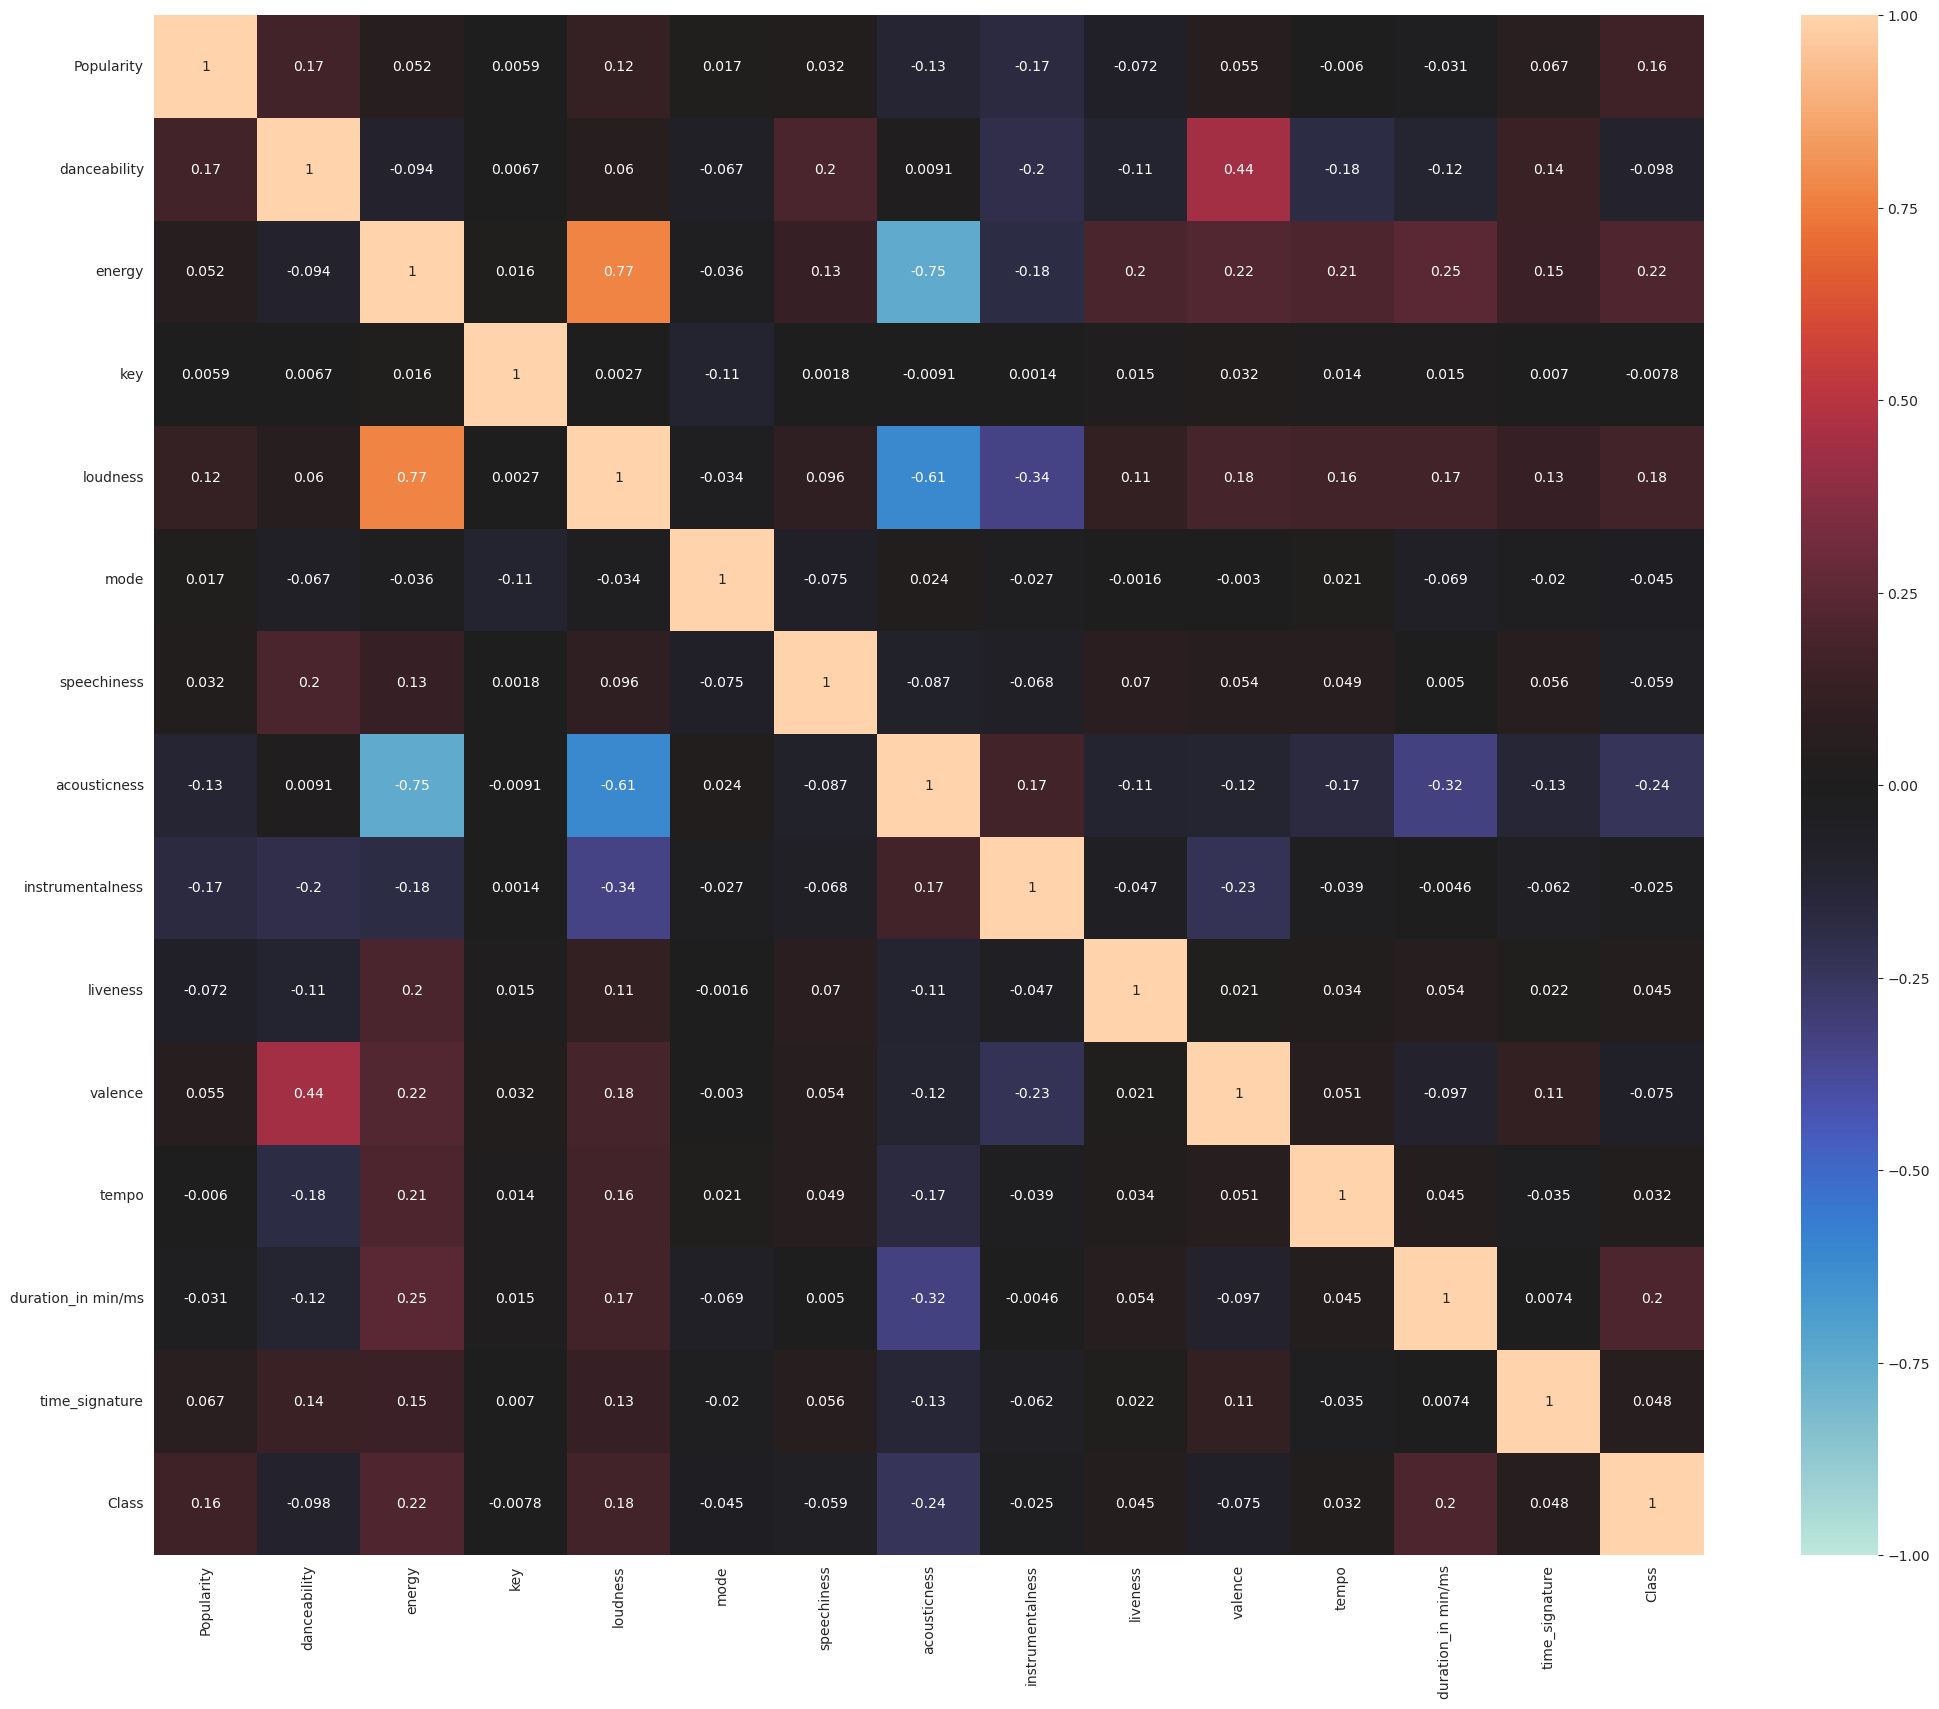

In [12]:
# Checking the correlation
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(data.select_dtypes(exclude=["object"]).corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Inference: There seems to be some high multi-correlation between the features. Skipping these for now, as the advanced ML Algorithms take care of multicollinearity.

## Data Pre-processing

In [13]:
# Show count and percentage of missing values in columns
print("Columns null value count and percentage\n")
nvc = pd.DataFrame(data.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/data.shape[0],3)*100
print(nvc)

Columns null value count and percentage

                    Total Null Values  Percentage
Artist Name                         0         0.0
duration_in min/ms                  0         0.0
tempo                               0         0.0
valence                             0         0.0
liveness                            0         0.0
acousticness                        0         0.0
time_signature                      0         0.0
speechiness                         0         0.0
loudness                            0         0.0
energy                              0         0.0
danceability                        0         0.0
Track Name                          0         0.0
mode                                0         0.0
Class                               0         0.0
Popularity                        428         2.4
key                              2014        11.2
instrumentalness                 4377        24.3


In [14]:
# handling missing values

# "Popularity" column is non-categorical and has 2% null values which is relatively small
# hence replacing null values with the mean
# Create a SimpleImputer object
mean_imputer = SimpleImputer(strategy="mean")
data['Popularity'] = mean_imputer.fit_transform(data[['Popularity']])

In [15]:
# "key" column is categorical and has 11% null values which is relatively small
# hence replacing null values with the mode

mode_imputer = SimpleImputer(strategy="most_frequent")
data['key'] = mode_imputer.fit_transform(data[['key']])

In [16]:
#"instrumentalness" column has relatively substantial amount of missing values (24%)
# hence using KNN to predict missing values

# Create a KNN imputer object with k=5
knn_imputer = KNNImputer(n_neighbors=5)

# Replace null values in "instrumentalness" column with KNN imputation
columns_to_impute = ["instrumentalness"]
data[columns_to_impute] = knn_imputer.fit_transform(data[columns_to_impute])

In [17]:
# confirm all missing values have been handled
data.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

In [18]:
# Removal of any Duplicate rows (if any)
data_copy_duplicates = data.copy()
counter = 0
rs,cs = data_copy_duplicates.shape

data.drop_duplicates(inplace=True)

if data.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-data.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [19]:
# # """
# # Removal of outlier:
#
# data_copy_outliers = data.copy()
#
# # The code calculates the first and third quartiles (Q1 and Q3) and the interquartile range (IQR) using the quantile() method.
# # The IQR is then used to identify the outliers: any data point whose value is above Q3 + 1.5*IQR or below Q1 - 1.5*IQR is considered an outlier.
# for i in feature_cols:
#     Q1 = data[i].quantile(0.25)
#     Q3 = data[i].quantile(0.75)
#     IQR = Q3 - Q1
#     data = data[data[i] <= (Q3+(1.5*IQR))]
#     data = data[data[i] >= (Q1-(1.5*IQR))]
#     data = data.reset_index(drop=True)
#
# print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(data_copy_outliers.shape[0]))
# print('After removal of outliers, The dataset now has {} samples.'.format(data.shape[0]))
# # """

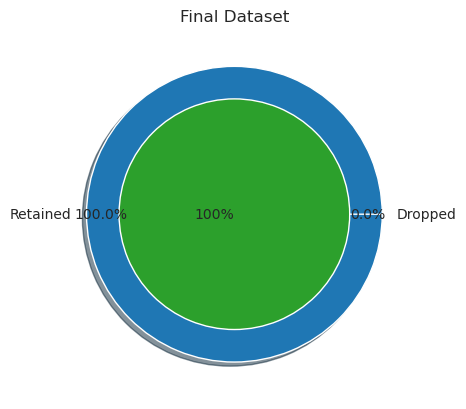


Observation: After the cleanup process, 0 samples were dropped, while retaining 100.0% of the data.


In [20]:
# Final Dataset size after performing Preprocessing

plt.title('Final Dataset')
plt.pie([data.shape[0], original_data_copy.shape[0]-data.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([data.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mObservation:\033[0m After the cleanup process, {original_data_copy.shape[0]-data.shape[0]} samples were dropped, \
while retaining {round((data.shape[0]*100/(original_data_copy.shape[0])),2)}% of the data.')

## Feature Selection and Engineering

In [21]:
# apply one-hot encoding on "mode" and "time_signature" because they are categorical features with 5 or fewer classes
features_df = data[feature_cols]
features_df_oh = pd.get_dummies(features_df, columns=['time_signature', 'mode'])
print("New number of features: {0}".format(len(features_df_oh.columns)))
print("\nFEATURES :")
for i in range(len(features_df_oh.columns)):
    print("{0}. {1}".format(i+1, features_df_oh.columns[i]))

New number of features: 18

FEATURES :
1. Popularity
2. danceability
3. energy
4. key
5. loudness
6. speechiness
7. acousticness
8. instrumentalness
9. liveness
10. valence
11. tempo
12. duration_in min/ms
13. time_signature_1
14. time_signature_3
15. time_signature_4
16. time_signature_5
17. mode_0
18. mode_1


In [22]:
# target dataframe
y = data[target_col]
# features dataframe
X = features_df_oh
# split data into train and test sets, 70% and 30% respectively, with random_state of 42, and stratify to ensure distribution is consistent in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, shuffle=True, stratify=y)

In [23]:
# # standardize
# # Standard Scaler (also known as Z-score normalization) scales the data such that the mean is 0 and the standard deviation is 1.
# # This technique is useful when the features in the data are normally distributed, or when you don't know the distribution of the data.
# # Standard Scaler works well for algorithms that assume normally distributed data, such as linear regression, logistic regression, and neural networks.
#
# # initialize the standardScaler object
# standardScaler = StandardScaler()
# # fit the standardScaler object to the train data
# standardScaler.fit(X_train)
# # transform both the train and test data with standardScaler object fitted to train data
# X_train_std = standardScaler.transform(X_train)
# X_test_std = standardScaler.transform(X_test)
#
# # Min-Max Scaler scales the data such that the range of values is between 0 and 1.
# # This technique is useful when you know the range of the data and when the features are not normally distributed.
# # Min-Max Scaler works well for algorithms that do not assume any specific distribution of the data, such as decision trees and SVMs.
#
# # initialize the MinMaxScaler object
# minMaxScaler = MinMaxScaler()
# # fit the minMaxScaler object to the train data
# minMaxScaler.fit(X_train)
# # transform both the train and test data with standardScaler object fitted to train data
# X_train_min_max = minMaxScaler.transform(X_train)
# X_test_min_max = minMaxScaler.transform(X_test)

## Model Training and Creation

In [24]:
# Proposed models
# LogisticRegression
# SVC
# Random Forest
# Neural network (Multi-layer Perceptron)

In [25]:
# initialise global result dataframe
logloss_results_all_df = pd.DataFrame(columns=['Model', 'Train LogLoss', 'Test LogLoss'])

def calculate_train_test_logloss(ytrain, ytrain_prob, ytest, ytest_prob):
    # train validation
    # Calculate the LogLoss score for train set
    logloss_train = log_loss(ytrain, ytrain_prob)
    # test validation (generalization)
    # Calculate the LogLoss score for test set
    logloss_test = log_loss(ytest, ytest_prob)
    return logloss_train, logloss_test


In [26]:
def plot_calibration_curve(model, y_pred_prob, model_name):
    # Plot the calibration curve
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(model.classes_)):
        prob_true, prob_pred = calibration_curve(y_test == model.classes_[i], y_pred_prob[:, i])
        ax.plot(prob_pred, prob_true, label=f'class {i}')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.set_title('{} Calibration Curve'.format(model_name))
    ax.legend()
    plt.show()

In [27]:
def plot_confusion_matrix(ytest, ypred, model_name):
    # Calculate the confusion matrix
    cm = confusion_matrix(ytest, ypred)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('{} Confusion matrix'.format(model_name))
    plt.show()

In [28]:
# Logistic Regression
# create pipeline to standardize features and create a logistic regression model with max iteration of 1000
logisticRegression = Pipeline([('Standardizer', StandardScaler()), ('LogisticRegressionModel', LogisticRegression(max_iter=1000))])
# logisticRegression = LogisticRegression(max_iter=1000)
# fit pipeline to train data with standardized features
logisticRegression.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_lr = logisticRegression.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_lr = logisticRegression.predict_proba(X_test)
# get test predictions
y_test_pred_lr = logisticRegression.predict(X_test)

                 Model  Train LogLoss  Test LogLoss
0  Logistic Regression       1.336901      1.350787


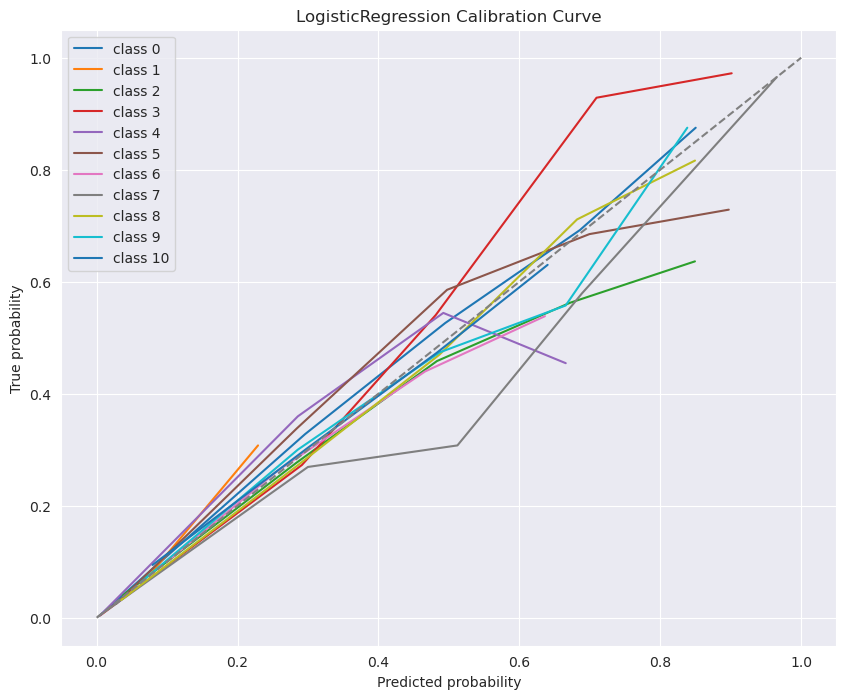

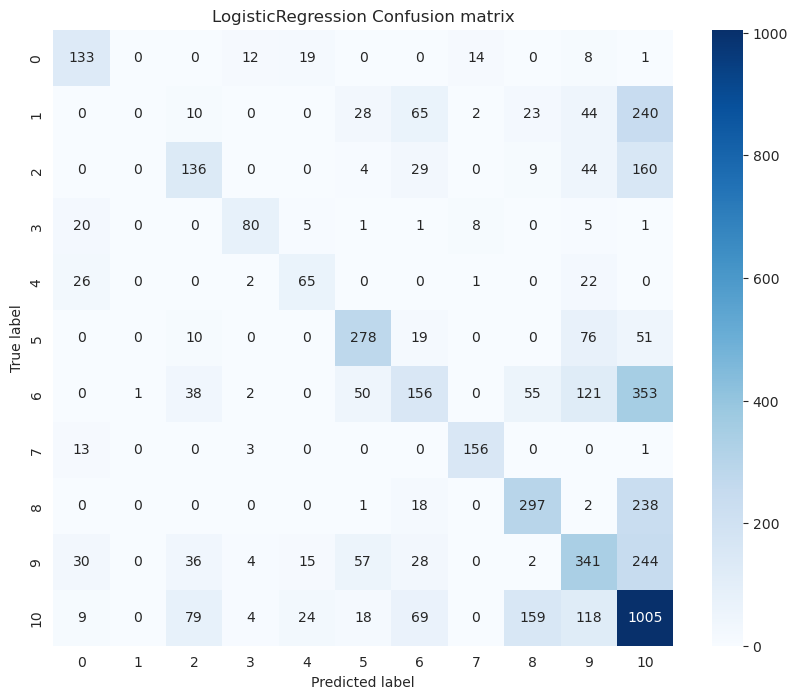

In [29]:
# print logloss validation for train and test predictions
logloss_train_lr, logloss_test_lr = calculate_train_test_logloss(y_train, y_train_prob_lr, y_test, y_test_prob_lr)

# create a pandas dataframe to store the results
logloss_results_lr_dict = {'Model': ['Logistic Regression'],
                           'Train LogLoss': [logloss_train_lr],
                           'Test LogLoss': [logloss_test_lr]}
logloss_results_lr_df = pd.DataFrame(logloss_results_lr_dict)
# print logloss result
print(logloss_results_lr_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Logistic Regression',
                                                        'Train LogLoss': logloss_train_lr,
                                                        'Test LogLoss': logloss_test_lr}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(logisticRegression, y_test_prob_lr, "LogisticRegression")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_lr, "LogisticRegression")

In [30]:
# Support Vector Classifier

# create pipeline to standardize features and create a Support Vector Classifier model with max iteration of 1000
svc = Pipeline([('Standardizer', MinMaxScaler()), ('SVC', SVC(max_iter=1000, kernel='rbf', probability=True))])
# svc = SVC(max_iter=1000, kernel='rbf', probability=True)
# fit pipeline to train data minmax scaled features

svc.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_svc = svc.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_svc = svc.predict_proba(X_test)
# get test predictions
y_test_pred_svc = svc.predict(X_test)

                       Model  Train LogLoss  Test LogLoss
0  Support Vector Classifier       1.420803      1.463175


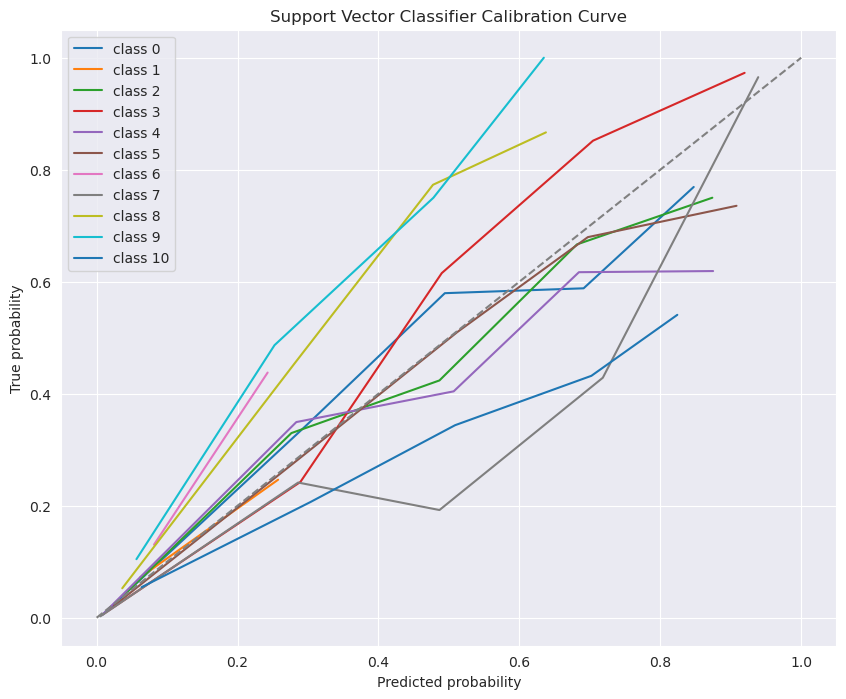

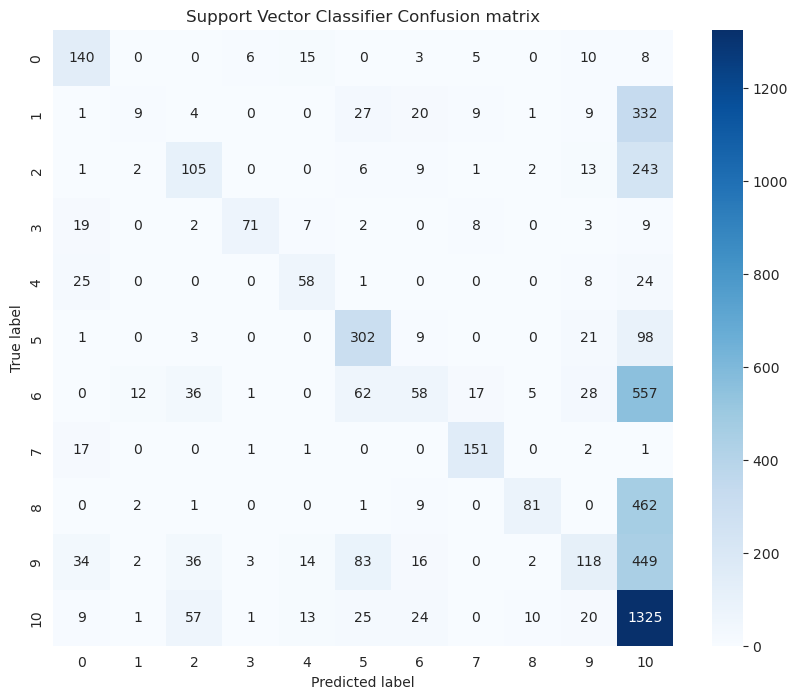

In [31]:
# print logloss validation for train and test predictions
logloss_train_svc, logloss_test_svc = calculate_train_test_logloss(y_train, y_train_prob_svc, y_test, y_test_prob_svc)

# create a pandas dataframe to store the results
logloss_results_svc_dict = {'Model': ['Support Vector Classifier'],
                            'Train LogLoss': [logloss_train_svc],
                            'Test LogLoss': [logloss_test_svc]}
logloss_results_svc_df = pd.DataFrame(logloss_results_svc_dict)
# print logloss result
print(logloss_results_svc_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Support Vector Classifier',
                                                        'Train LogLoss': logloss_train_svc,
                                                        'Test LogLoss': logloss_test_svc}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(svc, y_test_prob_svc, "Support Vector Classifier")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_svc, "Support Vector Classifier")

In [32]:
# Random Forest Classifier

# create pipeline to standardize features and create a Random Forest Classifier model
rfc = Pipeline([('Standardizer', MinMaxScaler()), ('RFC', RandomForestClassifier(n_estimators=100, random_state=42))])
# fit pipeline to train data
rfc.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_rfc = rfc.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_rfc = rfc.predict_proba(X_test)
# get test predictions
y_test_pred_rfc = rfc.predict(X_test)

                      Model  Train LogLoss  Test LogLoss
0  Random Forest Classifier       0.332659      1.570626


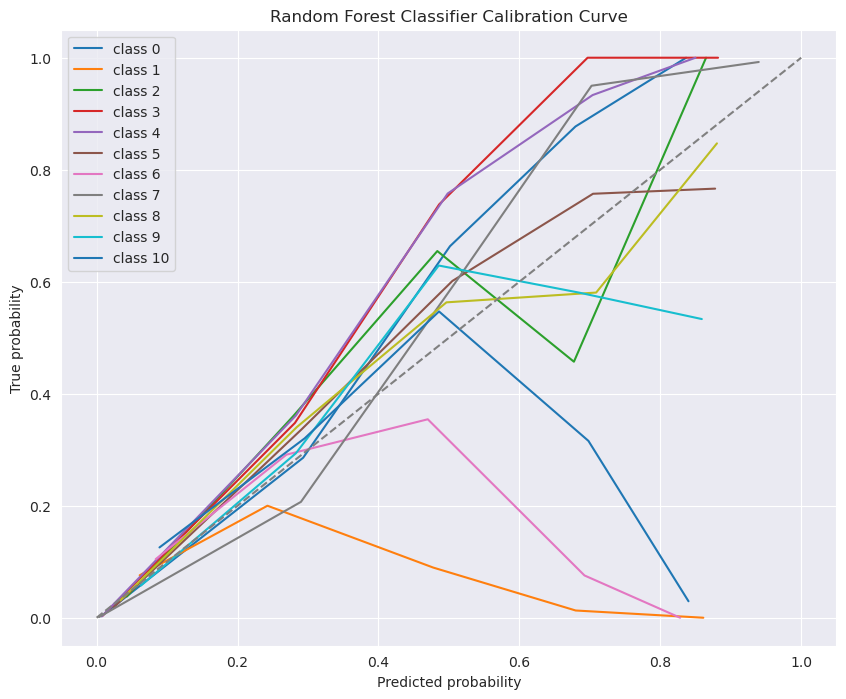

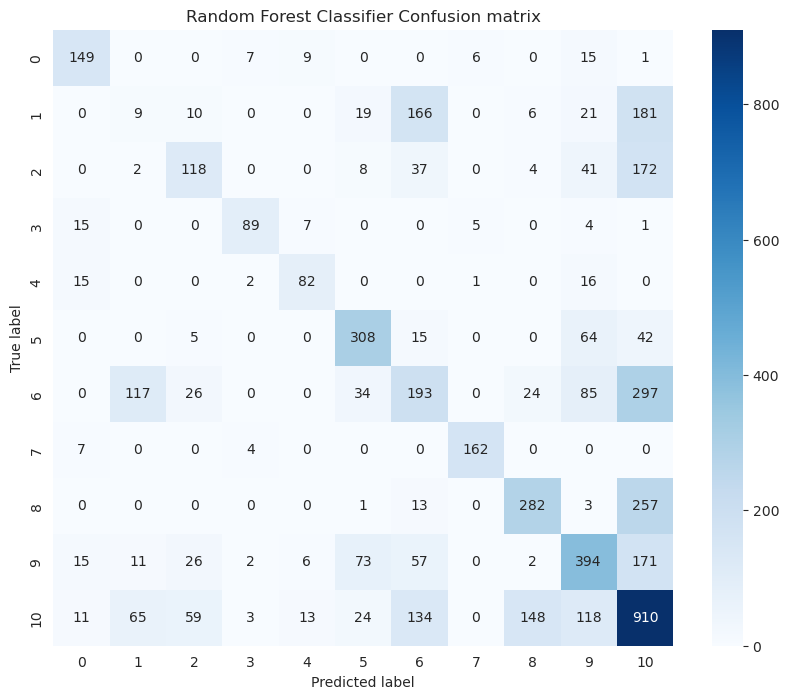

In [33]:
# print logloss validation for train and test predictions
logloss_train_rfc, logloss_test_rfc = calculate_train_test_logloss(y_train, y_train_prob_rfc, y_test, y_test_prob_rfc)

# create a pandas dataframe to store the results
logloss_results_rfc_dict = {'Model': ['Random Forest Classifier'],
                            'Train LogLoss': [logloss_train_rfc],
                            'Test LogLoss': [logloss_test_rfc]}
logloss_results_rfc_df = pd.DataFrame(logloss_results_rfc_dict)
# print logloss result
print(logloss_results_rfc_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Random Forest Classifier',
                                                        'Train LogLoss': logloss_train_rfc,
                                                        'Test LogLoss': logloss_test_rfc}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(rfc, y_test_prob_rfc, "Random Forest Classifier")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_rfc, "Random Forest Classifier")

In [34]:
# Neural Network (Multi-layer perceptron)

# initialize model
neural_net = Sequential()
# define number of features
num_of_features = 18
# define number of classes
num_of_classes = 11
# Input Layer
neural_net.add(Input(shape=(num_of_features,), name='Input-Layer'))
# Hidden Layer 1
neural_net.add(Dense(64, activation='relu', name='Hidden-Layer-1'))
# Hidden Layer 2
neural_net.add(Dense(32, activation='relu', name='Hidden-Layer-2'))
# Output Layer
neural_net.add(Dense(num_of_classes, activation = 'softmax', name='Output-Layer'))
# optimizer to reduce loss
adam = Adam()
# compile model
neural_net.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['categorical_crossentropy'])

# create pipeline to standardize features and create a Multi Layer Perceptron model
mlp = Pipeline([('Standardizer', StandardScaler()), ('mlp', neural_net)])
# one hot encode target train set to work with keras nn
y_train_oh = to_categorical(y_train, 11)
# y_test_oh = to_categorical(y_test, 11)
# fit pipeline to train data
mlp.fit(X_train, y_train_oh, mlp__epochs=100, mlp__batch_size=32)

# Generate predicted probabilities for the train set
y_train_prob_mlp = mlp.predict(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_mlp = mlp.predict(X_test)
# get test predictions
y_test_pred_mlp = np.argmax(y_test_prob_mlp, axis=1)


Epoch 1/100


2023-03-28 23:36:33.708577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-28 23:36:33.708595: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 23:36:33.708612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emeka-Latitude-5490): /proc/driver/nvidia/version does not exist
2023-03-28 23:36:33.708800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


394/394 [==============================] - 1s 1ms/step - loss: 1.6468 - categorical_crossentropy: 1.6468
Epoch 2/100
394/394 [==============================] - 0s 1ms/step - loss: 1.3433 - categorical_crossentropy: 1.3433
Epoch 3/100
394/394 [==============================] - 0s 1ms/step - loss: 1.3018 - categorical_crossentropy: 1.3018
Epoch 4/100
394/394 [==============================] - 0s 1ms/step - loss: 1.2795 - categorical_crossentropy: 1.2795
Epoch 5/100
394/394 [==============================] - 1s 1ms/step - loss: 1.2648 - categorical_crossentropy: 1.2648
Epoch 6/100
394/394 [==============================] - 1s 1ms/step - loss: 1.2547 - categorical_crossentropy: 1.2547
Epoch 7/100
394/394 [==============================] - 0s 1ms/step - loss: 1.2417 - categorical_crossentropy: 1.2417
Epoch 8/100
394/394 [==============================] - 0s 1ms/step - loss: 1.2346 - categorical_crossentropy: 1.2346
Epoch 9/100
394/394 [==============================] - 0s 1ms/step - loss: 1

                    Model  Train LogLoss  Test LogLoss
0  Multi layer perceptron       1.032234       1.34982


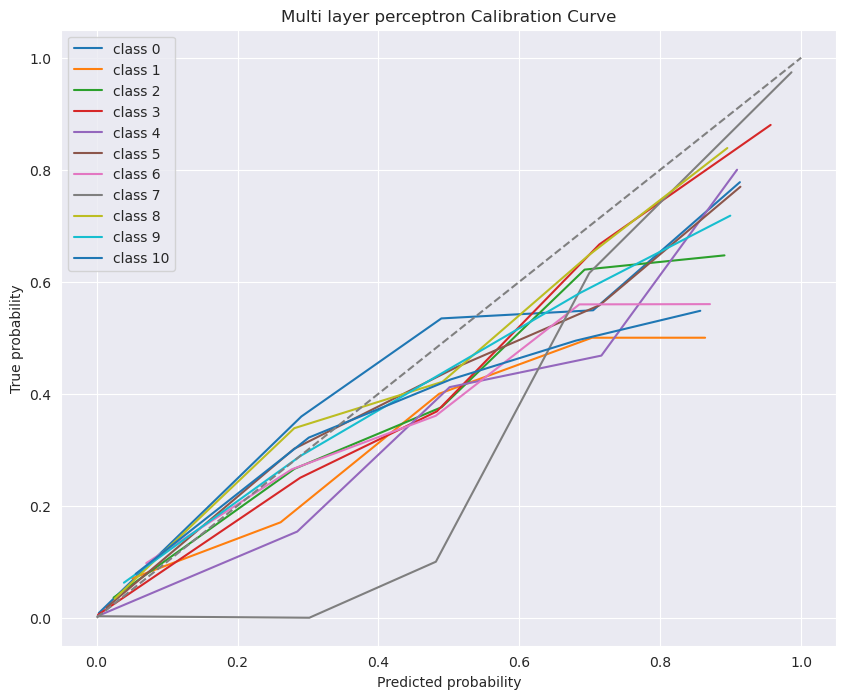

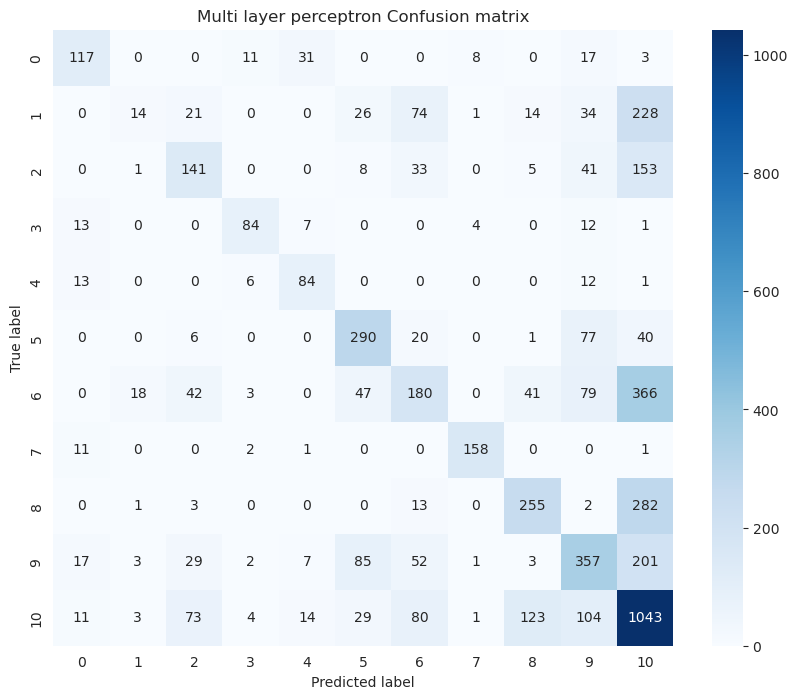

In [35]:
# print logloss validation for train and test predictions
logloss_train_mlp, logloss_test_mlp = calculate_train_test_logloss(y_train, y_train_prob_mlp, y_test, y_test_prob_mlp)

# create a pandas dataframe to store the results
logloss_results_mlp_dict = {'Model': ['Multi layer perceptron'],
                            'Train LogLoss': [logloss_train_mlp],
                            'Test LogLoss': [logloss_test_mlp]}
logloss_results_mlp_df = pd.DataFrame(logloss_results_mlp_dict)
# print logloss result
print(logloss_results_mlp_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Multi layer perceptron',
                                                        'Train LogLoss': logloss_train_mlp,
                                                        'Test LogLoss': logloss_test_mlp}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(rfc, y_test_prob_mlp, "Multi layer perceptron")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_mlp, "Multi layer perceptron")

In [36]:
# test and train log loss for all models
print(logloss_results_all_df)

                       Model  Train LogLoss  Test LogLoss
0        Logistic Regression       1.336901      1.350787
1  Support Vector Classifier       1.420803      1.463175
2   Random Forest Classifier       0.332659      1.570626
3     Multi layer perceptron       1.032234      1.349820


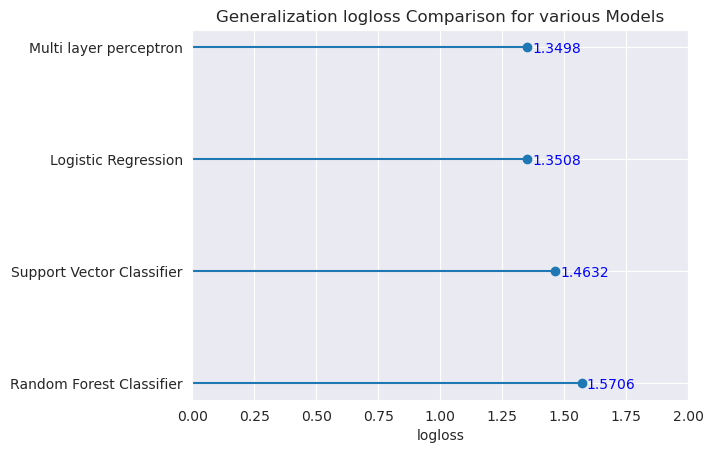

In [37]:
# logloss for generalisation test
EMC = logloss_results_all_df.copy()
EMC.index = ['Logistic Regression', 'Support Vector Classifier', 'Random Forest Classifier', 'Multi layer perceptron']
R2 = round(EMC['Test LogLoss'].sort_values(ascending=False),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('Generalization logloss Comparison for various Models')
plt.xlabel('logloss')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v), color='blue')
    # plt.text(i, v+1, str(v), ha="center")
plt.xlim([0,2])
plt.show()